In [6]:
import os
import sys
sys.path.append('/home/sanghyun/file/Nusaw/Realworld/ravens')
sys.path.append('/home/sanghyun/file/Nusaw/Realworld')

from ravens import tasks
from ravens.environments.environment_real import RealEnvironment
from ravens.utils import utils

from real_bot.perception.detection_agent import ObjectDetectorAgent
# from real_bot.perception.get_speech import speech_to_command

# from custom_utils.llm_utils import *
import numpy as np
import prompts
import os
from prompts.realworld.object_setup import OBJECT_DICT
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from PIL import Image
import time
from omegaconf import OmegaConf

def main():
    cfg = OmegaConf.load('/home/sanghyun/file/Nusaw/Realworld/real_bot/rw_config/inference.yaml')  # 구성 파일 경로 지정
    return cfg
cfg = main()

ModuleNotFoundError: No module named 'owl_vit'

In [3]:
cfg['plan_mode'] = 'pre-infered'

In [5]:
env = RealEnvironment(task_name=cfg['task'])
task = tasks.names[cfg['task']]()
# llm_agent = LLMAgent()
# print(f'@@@ LLM type: {cfg.llm_type} plan mode: {cfg.plan_mode}')

task_name = cfg['task'].replace('real-world-','').replace('-','_')
agent = ObjectDetectorAgent(task=task_name)
agent.detector.model.eval()

step_cnt = 1
np.random.seed(12)
env.seed(12)
env.set_task(task)
# info = env.info

done = False
plan_list = None



## Display Client Start ##
## Franka Client Start ##
## Speech Client Start ##


In [4]:
final_goal = "play the game"
demo_context = None
obs_context = None
command_modality = 0

# 0: speech, 1: vision + speech, 2: video + speech, 3: video + image + speech


In [5]:
# prompt_cls = prompts.names[cfg['task']]()
# fewshot_prompt = prompt_cls.prompt(command_modality)

goal_name = final_goal.split(' ')[0]

objects =['book',
 'bookshelf',
 'coke',
 'mouse',
 'pencil',
 'pencil holder',
 'setting point1',
 'trash',
 'trash can']
objects_str = ', '.join(objects)

obs, info_dict = env.reset()

obs_img = Image.open(f'/home/shyuni5/file/CORL2024/Sembot/real_bot/save_vision/obs/image_obs_{step_cnt}.png')
if not cfg['plan_mode'] =='pre-infered':
    if command_modality == 1:
        prompt_extract_state = env.task.prompt_extract_state + f'All possible objects: {objects_str}'
        obs_context = llm_agent.gemini_generate_context(prompt_extract_state, obs_img)

        human_img = Image.open('/home/shyuni5/file/CORL2024/Sembot/real_bot/save_vision/obs/human_image.png')
        prompt_extract_goal = f"[Final goal] {final_goal}. Please change [Final goal] to a command that includes a specific object. Example) pick up the red dice."  + f'All possible objects: {objects_str}'
        final_goal = llm_agent.gemini_generate_context(prompt_extract_goal, human_img)

    elif command_modality == 2:
        prompt_extract_demo = "Please explain the human behavior in this video."
        prompt_extract_demo += f'\nAll possible objects: {objects_str}'
        demo_context = llm_agent.gemini_generate_video_context(prompt_extract_demo, 'demo_glasses.mp4')

    elif command_modality == 3:
        prompt_extract_state = env.task.prompt_extract_state + f'All possible objects: {objects_str}'
        obs_context = llm_agent.gemini_generate_context(prompt_extract_state, obs_img)
        
        prompt_extract_demo = f"Please describe the actions of the person appearing in the video. {fewshot_prompt}"  + f'All possible objects: {objects_str}' + 'Possible Actions: move, pick, place, rotate, push, pull, sweep.'
        demo_context = llm_agent.gemini_generate_video_context(prompt_extract_demo, 'demo_glasses.mp4')

        human_img = Image.open('/home/shyuni5/file/CORL2024/Sembot/real_bot/save_vision/obs/human_image.png')
        prompt_extract_goal = f"[Final goal] {final_goal}. Please change [Final goal] to a command that includes a specific object. Example) pick up the red dice."  + f'All possible objects: {objects_str}'
        final_goal = llm_agent.gemini_generate_context(prompt_extract_goal, human_img)

franka client sent!!
franka client received!!


In [6]:
# time.sleep(5)

Plan: pick the <book>
target1_obj: book   target2_obj: None stpet_cnt: 1
franka client sent!!
franka client received!!
Plan: place the <bookshelf>
target1_obj: bookshelf   target2_obj: None stpet_cnt: 2
franka client sent!!
franka client received!!
Plan: pick the <pencil>
target1_obj: pencil   target2_obj: None stpet_cnt: 3
franka client sent!!
franka client received!!
Plan: place the <pencil holder>
target1_obj: pencil holder   target2_obj: None stpet_cnt: 4
franka client sent!!
franka client received!!
Plan: pick the <mouse>
target1_obj: mouse   target2_obj: None stpet_cnt: 5
franka client sent!!
franka client received!!
Plan: place the <setting point1>
target1_obj: setting point1   target2_obj: None stpet_cnt: 6
franka client sent!!
franka client received!!
Plan: pick the <coke>
target1_obj: coke   target2_obj: None stpet_cnt: 7
franka client sent!!
franka client received!!
Plan: place the <trash can>
target1_obj: trash can   target2_obj: None stpet_cnt: 8
franka client sent!!
frank

IndexError: list index out of range

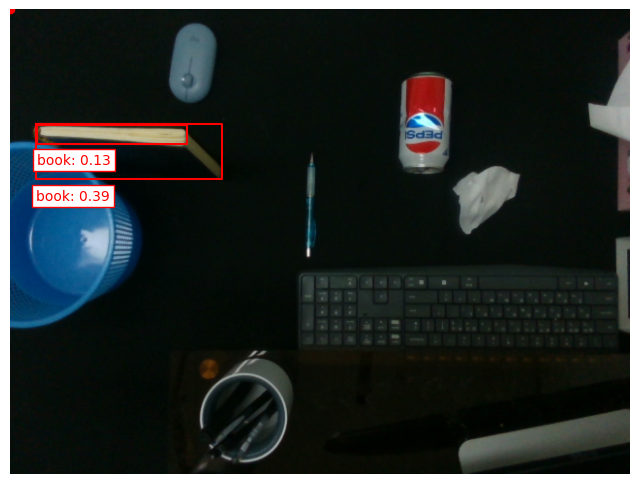

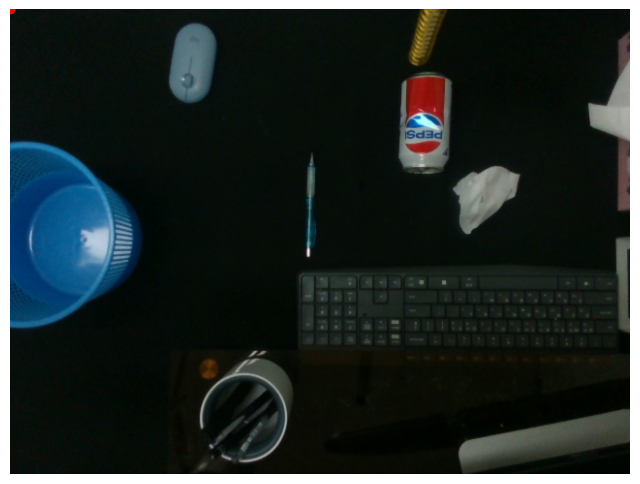

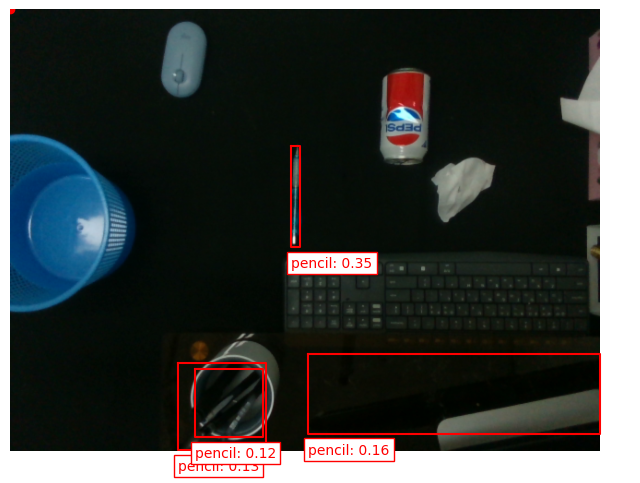

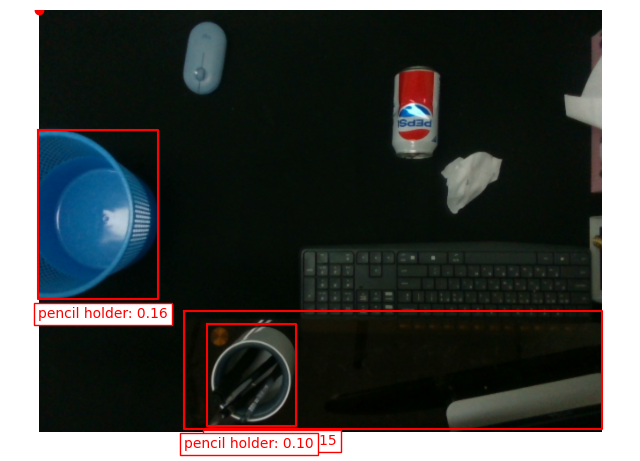

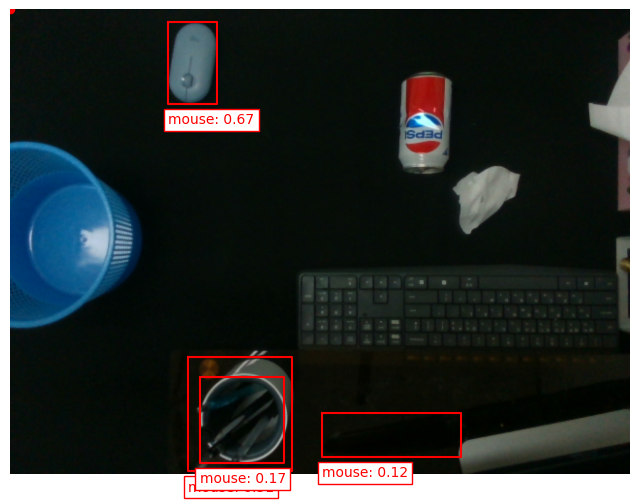

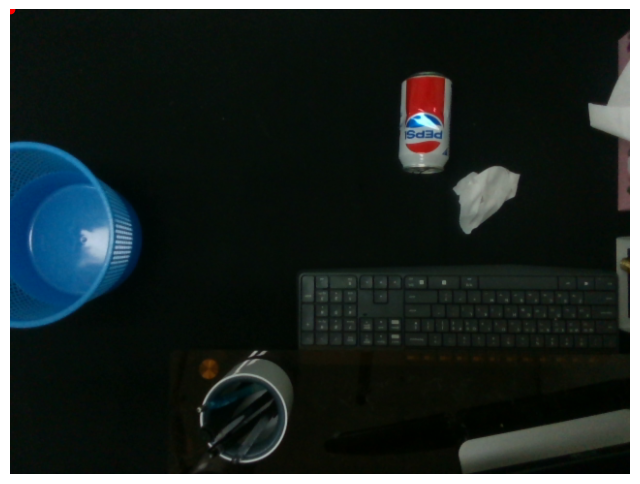

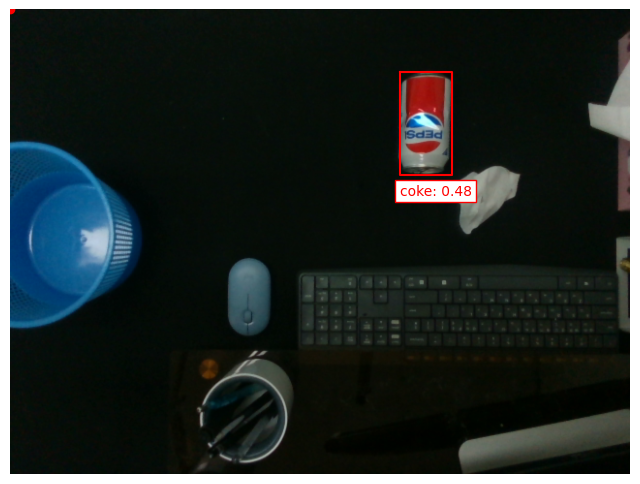

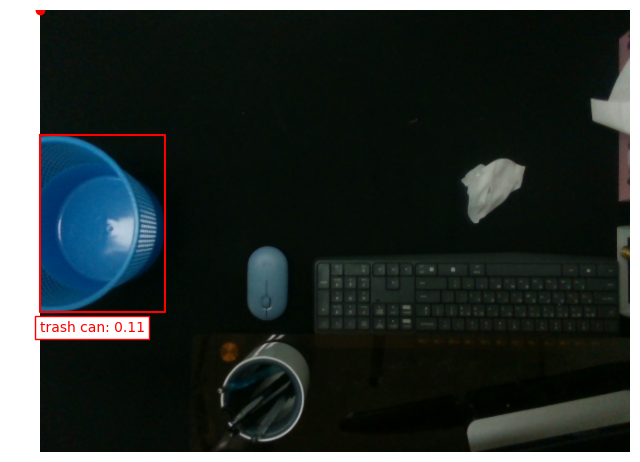

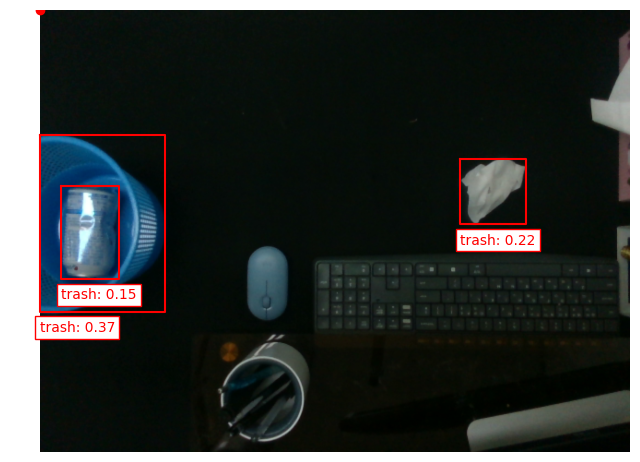

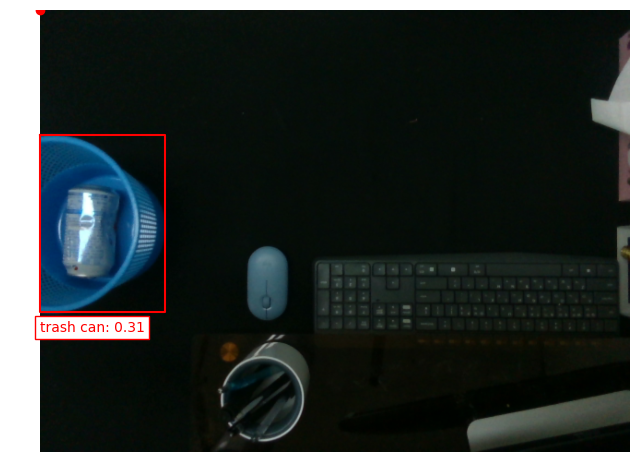

In [7]:
while not done:
    obs_img = Image.open(f'/home/shyuni5/file/CORL2024/Sembot/real_bot/save_vision/obs/image_obs_{step_cnt}.png')
    if cfg.plan_mode == 'closed_loop': # from LLM 
        prompt_extract_state = env.task.prompt_extract_state + f'All possible objects: {objects_str}'
        obs_context = llm_agent.gemini_generate_context(prompt_extract_state, obs_img)
    text_context = '[Context] '
    ##############################################################################
    if (cfg.plan_mode == 'open_loop') and step_cnt == 1:
        if demo_context is not None:
            print("demo_context: ", demo_context)
            text_context += f'{demo_context}\n'
        if obs_context is not None:
            print(f"@@@ Context from vision: {obs_context}")
            text_context += f'{obs_context}\n' 
    text_context += f'All possible objects: {objects_str}'
    text_context += 'Possible Actions: pick, pick, place, rotate, push, pull, sweep.'
    planning_prompt = \
    f'[Goal] {final_goal} {text_context}'
    
    if cfg.plan_mode == 'closed_loop':
        joined_categories = ", ".join(objects)
        planning_prompt = f'{planning_prompt}' \
                        f'[State of Step {step_cnt}] {joined_categories} '                  
    else:
        planning_prompt = f'{planning_prompt}'

    ##############################################################################
    if cfg.plan_mode == 'closed_loop':
        planning_prompt +=  f'[Plan {step_cnt}] '
        if cfg.llm_type == 'gemini':
            gen_act = llm_agent.gemini_gen_act(fewshot_prompt, planning_prompt, obs_img)
        elif cfg.llm_type == 'gpt4':
            gen_act = llm_agent.gpt4_gen_act(fewshot_prompt, planning_prompt)
        lang_action = gen_act

    elif cfg.plan_mode == 'open_loop' and step_cnt == 1:
        if plan_list == None:
            if cfg.llm_type == 'gemini':
                plan_list = llm_agent.gemini_gen_all_plan(fewshot_prompt, planning_prompt)
            elif cfg.llm_type == 'gpt4':
                plan_list = llm_agent.gpt4_gen_all_plan(fewshot_prompt, planning_prompt)
        lang_action = plan_list[step_cnt-1]
    else:
        # plan_list= ["pull the <first drawer handle>", #"push the <drawer handle 2>",
        #             "pull the <second drawer handle>", #"push the <drawer handle 4>", 
        #             "pick up the <coffee stick>",
        #             "place in the <setting point1>",
        #             "pick the <blue cup> to the <setting point2>",
        #             "done imitating your behavior."]
        # plan_list= ["pick the <blue cup> to the <setting point2>",
        #         "done imitating your behavior."]

        # plan_list = [
        #             "move the <baseball> to the <green basket>",
        #              "move the <blue cup> to the <setting point1>",
        #              "pull the <first drawer handle>",
        #              "pick up the <coffee stick>",
        #              "place in the <setting point2>",
        #              "push the <first drawer handle left>",
        #              "pull the <second drawer handle>",
        #              "pick up the <yellow dice>",
        #              "place in the <setting point2>",
        #              "push the <second drawer handle left>",
        #              "done imitating your behavior."]

        # plan_list = [
        #             "move the <green block> to the <green circle plate>",
        #             "move the <blue block> to the <blue circle plate>",
        #             "move the <yellow block> to the <yellow circle plate>",
        #             "move the <red block> to the <red circle plate>",
        #             "move the <yellow alphabet V> to the <yellow circle plate>",
        #             "move the <green alphabet S> to the <green circle plate>",
        #             "done imitating your behavior."]

        # plan_list = [
        #     "move <disk Orange_4_A> to the <B>.",
        #     "move <disk Green_3_A> to the <C>.",
        #     "move <disk Orange_1_B> to the <C>.",
        #     "move <disk Purple_2_A> to the <B>.",
        #     "move <disk Orange_2_C> to the <A>.",
        #     "move <disk Green_1_C> to the <B>.",
        #     "move <disk Orange_2_A> to the <B>.",
        #     "move <disk Blue_1_A> to the <C>.",
        #     "move <disk Orange_3_B> to the <C>.",
        #     "move <disk Green_2_B> to the <A>.",
        #     "move <disk Orange_2_C> to the <A>.",
        #     "move <disk Purple_1_B> to the <C>.",
        #     "move <disk Orange_2_A> to the <B>.",
        #     "move <disk Green_1_A> to the <C>.",
        #     "move <disk Orange_1_B> to the <C>."
        # ]
        plan_list = [
                    "pick the <book>",
                    "place the <bookshelf>",
                    "pick the <pencil>",
                    "place the <pencil holder>",
                    "pick the <mouse>",
                    "place the <setting point1>",
                    "pick the <coke>",
                    "place the <trash can>",
                    "pick the <trash>",
                    "place the <trash can>",
                    ]

        lang_action = plan_list[step_cnt-1]
        
    print(f"Plan: {lang_action}")
    if ('done' in lang_action) or ('Done' in lang_action):
        print("Task End!!!")
        # env.send_display_server(4, 'end')
        env.server_close()
        break

    elif env.task.max_steps < step_cnt:
        break

    obs['objects'] = objects
    obs['lang_action'] = lang_action
    obs['step_cnt'] = step_cnt
    act = agent.forward(obs)
    step_cnt += 1
    # env.send_display_server(3, 'end')

    if act == -1:
        continue
    # if step_cnt == 1:
    #     env.send_display_server(4, 'start')

    # Continue with the rest of the code
    z = env.step(act)
    try:
        obs, reward, done, info = z
    except ValueError:
        obs, reward, done, info, action_ret_str = z
        print(action_ret_str)

    planning_prompt = f'{planning_prompt}{lang_action}. '
